In [1]:
import torch 
import torch.nn as nn 

torch.manual_seed(2)

c:\Users\EonKim\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


$$ \frac{dC}{dW_2} = \frac{dC}{dY_4} \cdot \frac{dY_4}{dY_3} \cdot \frac{dY_3}{dW_2} $$
$$ \frac{dC}{db_2} = \frac{dC}{dY_4} \cdot \frac{dY_4}{dY_3} \cdot \frac{dY_3}{db_2} $$
$$ \frac{dC}{dW_1} = \frac{dC}{dY_4} \cdot \frac{dY_4}{dY_3} \cdot \frac{dY_3}{dY_2} \cdot \frac{dY_2}{dY_1} \cdot \frac{dY_1}{dW_1} $$
$$ \frac{dC}{db_1} = \frac{dC}{dY_4} \cdot \frac{dY_4}{dY_3} \cdot \frac{dY_3}{dY_2} \cdot \frac{dY_2}{dY_1} \cdot \frac{dY_1}{db_1} $$

In [34]:
from sklearn import datasets 
from sklearn import preprocessing 

iris = datasets.load_iris()
X = torch.tensor(preprocessing.normalize(iris.data[:, :2]), dtype=torch.float)
y = torch.tensor(iris.target.reshape(-1, 1), dtype=torch.float)

In [78]:
X.shape, y.shape

(torch.Size([150, 2]), torch.Size([150, 1]))

In [75]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        
        self.input_dim = 2 
        self.hidden_dim = 32 
        self.output_dim = 3
        
        self.learning_rate = 0.001 
        self.w1 = torch.randn(self.input_dim, self.hidden_dim)
        self.b1 = torch.zeros((self.hidden_dim))
        
        self.w2 = torch.randn(self.hidden_dim, self.output_dim)
        self.b2 = torch.randn(self.output_dim)
        
    def sigmoid(self, s):
        return 1 / ( 1 + torch.exp(-s))

    def sigmoid_derivative(self, s):
        return s * (1 - s)
    
    def tanh(self, s):
        return (torch.exp(s) - torch.exp(-s)) / (torch.exp(s) + torch.exp(-s))

    def tanh_derivative(self, s):
        return 1 - torch.pow(s, 2)
    
    def forward(self, X):
        self.y1 = torch.matmul(X, self.w1) + self.b1 
        
        self.y2 = self.sigmoid(self.y1)
        
        self.y3 = torch.matmul(self.y2, self.w2) + self.b2
        
        y4 = self.sigmoid(self.y3)
        return y4

    def backward(self, X, l, y4):
        self.dC_dy4 = y4 - l
        
        self.dy4_dy3 = self.sigmoid_derivative(y4)
        self.dy3_dw2 = self.y2 
        
        self.y4_delta = self.dC_dy4 * self.dy4_dy3 
        
        self.dC_dw2 = torch.matmul(torch.t(self.dy3_dw2), self.y4_delta)
        self.dC_db2 = torch.sum(self.y4_delta)
        
        self.dy3_dy2 = self.w2 
        self.dy2_dy1 = self.sigmoid_derivative(self.y2)
        
        self.y2_delta = torch.matmul(self.y4_delta, torch.t(self.dy3_dy2)) * self.dy2_dy1 
        self.dC_dw1 = torch.matmul(torch.t(X), self.y2_delta)
        self.dC_db1 = torch.sum(self.y2_delta) 

        self.w1 -= self.learning_rate * self.dC_dw1 
        self.w2 -= self.learning_rate * self.dC_dw2 
        self.b1 -= self.learning_rate * self.dC_db1 
        self.b2 -= self.learning_rate * self.dC_db2 
        
    def train(self, X, l):
        y4 = self.forward(X)
        self.backward(X, l, y4)

In [76]:
model = FNN()

loss_list = []

num_epochs = 1001

for epoch in range(num_epochs):
    y_hat = model(X)
    
    cross_entropy_loss = -(1/y.shape[0]) * torch.sum(torch.multiply(y, torch.log(y_hat)))
    
    # We have to take cross entropy loss over all our samples, 100 in this 2-class iris dataset
    mean_cross_entropy_loss = torch.mean(cross_entropy_loss).detach().item()
    
    # Print our mean cross entropy loss
    if epoch % 20 == 0:
        print('Epoch {} | Loss: {}'.format(epoch, mean_cross_entropy_loss))
    loss_list.append(mean_cross_entropy_loss)
    
    # (1) Forward propagation: to get our predictions to pass to our cross entropy loss function
    # (2) Back propagation: get our partial derivatives w.r.t. parameters (gradients)
    # (3) Gradient Descent: update our weights with our gradients
    model.train(X, y)

Epoch 0 | Loss: 9.119670867919922
Epoch 20 | Loss: 6.69555139541626
Epoch 40 | Loss: 6.51153039932251
Epoch 60 | Loss: 6.389831066131592
Epoch 80 | Loss: 6.274810314178467
Epoch 100 | Loss: 6.154539585113525
Epoch 120 | Loss: 6.022982120513916
Epoch 140 | Loss: 5.874863147735596
Epoch 160 | Loss: 5.703821659088135
Epoch 180 | Loss: 5.500678062438965
Epoch 200 | Loss: 5.2504377365112305
Epoch 220 | Loss: 4.925319194793701
Epoch 240 | Loss: 4.464056491851807
Epoch 260 | Loss: 3.684159755706787
Epoch 280 | Loss: 1.618038296699524
Epoch 300 | Loss: 0.3244049549102783
Epoch 320 | Loss: 0.2529853284358978
Epoch 340 | Loss: 0.2362871617078781
Epoch 360 | Loss: 0.232988178730011
Epoch 380 | Loss: 0.23450328409671783
Epoch 400 | Loss: 0.23763342201709747
Epoch 420 | Loss: 0.24101921916007996
Epoch 440 | Loss: 0.2441917508840561
Epoch 460 | Loss: 0.2471068948507309
Epoch 480 | Loss: 0.2498663365840912
Epoch 500 | Loss: 0.25257715582847595
Epoch 520 | Loss: 0.2553052306175232
Epoch 540 | Loss: 0.

<AxesSubplot:>

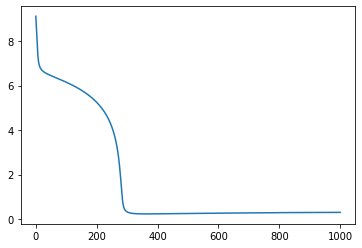

In [77]:
import pandas as pd
%matplotlib inline
pd.Series(loss_list).plot()